In [ ]:
!pip install flask==0.12.2
!pip install pyngrok==4.1.1
!pip install flask-ngrok
!pip install flasgger
!pip install flask_restful
!pip install deepface


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.0 MB/s 
  Attempting uninstall: flask
    Found existing installation: Flask 1.1.4
    Uninstalling Flask-1.1.4:
      Successfully uninstalled Flask-1.1.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=e2bdec03902a1f59139f94a50b0b3f9b50f1c82ba4aab3329a8ad45b90b5c106
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-p

In [ ]:
import os, sys

In [ ]:

from google.colab import drive
drive.mount('/content/mnt', force_remount = True)
nb_path = '/content/web'
#create a symbolic link for pointing to /content/mnt/My Drive/Colab Notebooks
os.symlink('/content/mnt/My Drive/Colab Notebooks/web_data', nb_path)
sys.path.insert(0, nb_path) 

Mounted at /content/mnt


In [ ]:
# Imports
import io
from urllib.request import urlopen

import flasgger
from flask_ngrok import run_with_ngrok
from flask_restful import Api, Resource, fields, marshal
from flask import Flask, render_template_string, request, redirect, render_template

# !pip install flask_restx
# from flask_restx import Api, Resource

In [ ]:
!ngrok authtoken "28oiEdNYHChc9RSn5dhIfzEMGpX_2ckxTxKib3KCtCFgqxrqy" #Without "" marks 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from deepface import DeepFace
import tensorflow as tf
import os.path
import json
import cv2


Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
class FindView(Resource):

  models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
  backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
  def get(self):
    files = os.listdir("/content/web/new")
    files = sorted(files)
    imglist = []
    for file in files:
        if '.jpg' in file: 
            imglist.append(file)
    json_string = json.dumps(imglist)
    print(json_string)
    return json_string


class FindViewModel:
  """
  A simple ViewModel that displays the PlatformView at /platform
  """

  def setup(self, api):
    api.add_resource(FindView, '/find')

In [ ]:
!pip install facenet_pytorch
from facenet_pytorch import InceptionResnetV1
from facenet_pytorch import MTCNN
import numpy as np
import torch
import tqdm 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()


mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(x):
    resnet.eval()

    x_aligned, prob = mtcnn(x, return_prob=True)

    # if x_aligned is not None:
    #    aligned = torch.stack(x_aligned).to(device)
    x_aligned = x_aligned.unsqueeze(0)


    embeddings = resnet(x_aligned).detach().cpu()
    # print(embeddings)

    return embeddings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/content/web/new/kjkjnaver_0019.jpg
torch.Size([1, 512])
Representations stored in  /content/web/new / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  39.486769676208496  seconds
['서강준', 'kjkjnaver_0019.jpg', 'kjkjgoogle_0008.jpg', 'kjkjnaver_0011.jpg', 'kjkjnaver_0001.jpg', 'kjkjgoogle_0024.jpg', 'kjkjnaver_0012.jpg', 'kjkj000.jpg', 'mkum.jpg', 'kjkjgoogle_0029.jpg', 'kj000.jpg']


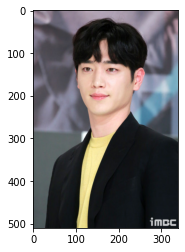

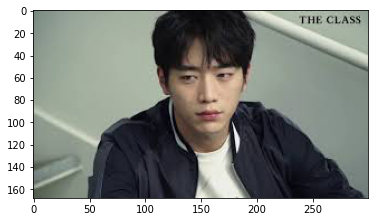

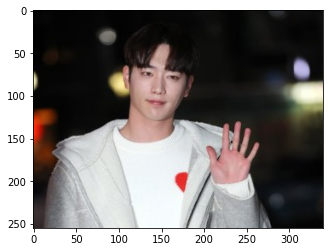

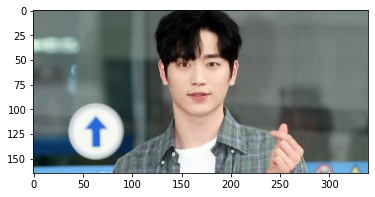

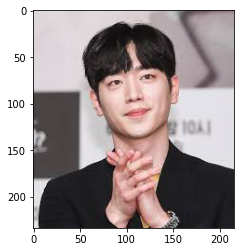

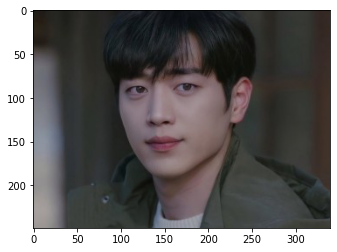

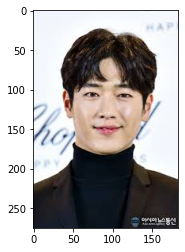

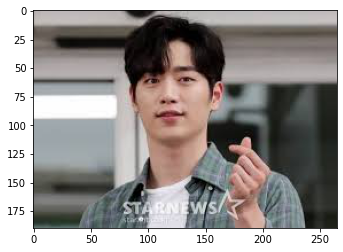

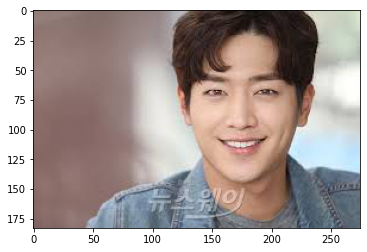

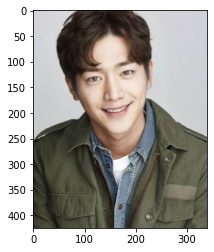

In [ ]:
#### 테스트셀

from PIL import Image
from deepface import DeepFace
from deepface.commons import functions
import joblib
import pandas as pd
import matplotlib.pyplot as plt


filename='kjkjnaver_0019.jpg'

dir_path = "/content/web/new"
#Load SVM Model
SVM_PATH = os.path.join(dir_path, 'svm.sav')
clf = joblib.load(SVM_PATH)

#Load Class index
json_path= os.path.join(dir_path, 'class.json')
with open(json_path, 'r') as f:
    json_data = json.load(f)
    classlist = pd.json_normalize(json_data)
    classlist = classlist.to_dict()


dir_path = "/content/web/new"
img_path= os.path.join(dir_path, filename)
print(img_path)

img = Image.open(img_path).convert('RGB')
testEmbeds = getEmbeds(img)
print(testEmbeds.shape)


response = []
result = clf.predict(testEmbeds)
for name, value in classlist.items(): 
  if(list(value.values())[0] == result):
    response.append(name)
    break

df = DeepFace.find(img_path=img_path, db_path=dir_path , distance_metric="euclidean", enforce_detection=False, model_name='Facenet')
filelist = df['identity']
minlen = min(10,len(filelist))
filelist = filelist[0:minlen]
for i in range(len(filelist)):
  response.append(os.path.basename(filelist[i]))

json_string = json.dumps(response, ensure_ascii=False).encode('utf8')
res_print = json.loads(json_string)
print(res_print)
for i in range(1, len(res_print)):
  dir_path = "/content/web/new"
  img_path= os.path.join(dir_path, res_print[i])
  img = Image.open(img_path)
  plt.imshow(img)
  plt.show()

# dir_path = "/content/web/new"
# img_path= os.path.join(dir_path, filename)
# print(img_path)

# img = Image.open(img_path).convert('RGB')

# #face detection and alignment
# # detected_and_aligned_face = DeepFace.detectFace(img_path, detector_backend = 'mtcnn')
# # print(detected_and_aligned_face)
# testEmbeds = getEmbeds(img)
# print(testEmbeds.shape)

# result = clf.predict(testEmbeds)
# for name, value in df.items(): 
#       if(list(value.values())[0] == result):
#         print(name)
#         break
# # print(df)


In [ ]:
from PIL import Image
from deepface import DeepFace
from deepface.commons import functions
import joblib

class FindWhoView(Resource):

  dir_path = "/content/web/new"

  #Load SVM Model
  SVM_PATH = os.path.join(dir_path, 'svm.sav')
  clf = joblib.load(SVM_PATH)

  #Load Class index
  json_path= os.path.join(dir_path, 'class.json')
  with open(json_path, 'r') as f:
      json_data = json.load(f)
      classlist = pd.json_normalize(json_data)
      classlist = classlist.to_dict()

  def get(self, filename):
    dir_path = "/content/web/new"
    img_path= os.path.join(dir_path, filename)
    print(img_path)

    img = Image.open(img_path).convert('RGB')
    testEmbeds = getEmbeds(img)
    print(f'embed는? {testEmbeds.shape}')

    # response = []
    response = {}
    result = clf.predict(testEmbeds)
    print(f'result? {result}')
    for name, value in classlist.items(): 
      if(list(value.values())[0] == result):
        # response.append(name)
        response['name'] = name
        break

    df = DeepFace.find(img_path=img_path, db_path=dir_path , distance_metric="euclidean", enforce_detection=False, model_name='Facenet')
    print(f'df는? {df}')
    filelist = df['identity']
    minlen = min(10,len(filelist))
    filelist = filelist[0:minlen]

    response['list'] = []
    for i in range(len(filelist)):
      response['list'].append(os.path.basename(filelist[i]))

    print(f'response는? {response}')
    json_string = json.dumps(response)
    return json_string

class FindWhoViewModel:
  """
  A simple ViewModel that displays the PlatformView at /platform
  """

  def setup(self, api):
    api.add_resource(FindWhoView, '/findWho/<string:filename>')

In [ ]:
class FindPersonView(Resource):

  models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
  backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
  def get(self, filename):
    dir_path = "/content/web/new"
    img_path= os.path.join(dir_path, filename)
    print(img_path)
    df = DeepFace.find(img_path=img_path, db_path=dir_path , distance_metric="euclidean", enforce_detection=False, model_name='Facenet')
    print(df)
    filelist = df['identity']
    minlen = min(10,len(filelist))
    filelist = filelist[0:minlen]

    response = []
    for i in range(len(filelist)):
      response.append(os.path.basename(filelist[i]))

    json_string = json.dumps(response)
    return json_string

class FindPersonViewModel:
  """
  A simple ViewModel that displays the PlatformView at /platform
  """

  def setup(self, api):
    api.add_resource(FindPersonView, '/find/<string:filename>')

In [ ]:
import pandas as pd

class FindPersonEmotionView(Resource):
  models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
  backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
  def get(self, emotionName):
    dir_path = "/content/web/new"
    json_path= os.path.join(dir_path, 'analysis.json')
    if os.path.exists(json_path):
        print(json_path)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
            df = pd.json_normalize(json_data)
            print(df)
            filelist = df.loc[df['emotion'] == emotionName]['filename']
            filelist = filelist.to_list()
            json_string = json.dumps(filelist)
            return json_string
    else:
      files = os.listdir(dir_path)
      resultlist = []
      for file in files:
        if '.jpg' in file: 
          img_path= os.path.join(dir_path, file)
          print(img_path)
          obj = DeepFace.analyze(img_path = img_path, actions = ['emotion'], enforce_detection=False)
          if emotionName == obj["dominant_emotion"]:
            resultlist.append(file)
      json_string = json.dumps(resultlist)
      return json_string

class FindPersonEmotionViewModel:
  def setup(self, api):
    api.add_resource(FindPersonEmotionView, '/findPersonEmotion/<string:emotionName>')

In [ ]:
class FindPersonEntityView(Resource):
  models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
  backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
  def get(self, gender):
    dir_path = "/content/web/new"
    json_path= os.path.join(dir_path, 'analysis.json')
    if os.path.exists(json_path):
      with open(json_path, 'r') as f:
          json_data = json.load(f)
          df = pd.json_normalize(json_data)
          filelist = df.loc[df['gender'] == gender]['filename']
          filelist = filelist.to_list()
          json_string = json.dumps(filelist)
          return json_string
    else:
      files = os.listdir(dir_path)
      resultlist = []
      for file in files:
        if '.jpg' in file: 
          img_path= os.path.join(dir_path, file)
          print(img_path)
          obj = DeepFace.analyze(img_path = img_path, actions = ['gender'], enforce_detection=False)
          if gender == obj['gender']:
            resultlist.append(file)
      json_string = json.dumps(resultlist)
      return json_string

class FindPersonEntityViewModel:
  """
  A simple ViewModel that displays the PlatformView at /platform
  """

  def setup(self, api):
    api.add_resource(FindPersonEntityView, '/findPersonEntity/<string:gender>')

In [ ]:
app = Flask(__name__, template_folder='/content/web/new', static_folder = '/content/web/new')
api = Api(app)

FindViewModel().setup(api)
FindPersonViewModel().setup(api)
FindPersonEmotionViewModel().setup(api)
FindPersonEntityViewModel().setup(api)
FindWhoViewModel().setup(api)

# Serve the Vue template with the interactive UI
@app.route("/")
def home():
  return render_template("index.html")

# Register Swagger to create API documentation at /apidocs
swg = flasgger.Swagger(app)

# Run the app
run_with_ngrok(app)

## Uncomment below to run the app
app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)


 * Running on http://6493-35-226-226-197.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/Jun/2022 00:42:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:17] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 00:42:19] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [18/Jun/2022 00:42:20] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 00:42:22] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:42:23] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:42:24] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:42:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:42:46] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 00:42:52] "GET /favicon.ico HTTP/1.1" 404 -


/content/web/new/dmdmgoogle_0015.jpg
There are  160  representations found in  representations_facenet.pkl


127.0.0.1 - - [18/Jun/2022 00:43:04] "GET /find/dmdmgoogle_0015.jpg HTTP/1.1" 200 -


find function lasts  0.9717288017272949  seconds
                                identity  Facenet_euclidean
0   /content/web/new/dmdmgoogle_0015.jpg           0.000000
1    /content/web/new/dmdmnaver_0025.jpg           5.427079
2    /content/web/new/dmdmnaver_0056.jpg           5.728564
3           /content/web/new/dmdm000.jpg           5.949780
4              /content/web/new/aewr.jpg           6.402688
5   /content/web/new/dmdmgoogle_0014.jpg           6.953008
6              /content/web/new/asdf.jpg           6.955944
7            /content/web/new/u,ii,u.jpg           7.357889
8    /content/web/new/iuiunaver_0046.jpg           8.152048
9   /content/web/new/kekegoogle_0040.jpg           8.155743
10  /content/web/new/wywygoogle_0082.jpg           8.550686
11            /content/web/new/awsef.jpg           8.709887
12   /content/web/new/wywynaver_0042.jpg           8.763746
13              /content/web/new/sh4.jpg           8.838350
14             /content/web/new/ewfe.jpg           

127.0.0.1 - - [18/Jun/2022 00:45:00] "GET /findWho/asdfa.jpg HTTP/1.1" 200 -


find function lasts  0.22801971435546875  seconds
df는?                                 identity  Facenet_euclidean
0             /content/web/new/asdfa.jpg           0.000000
1    /content/web/new/wywynaver_0042.jpg           6.935773
2              /content/web/new/grag.jpg           7.318891
3             /content/web/new/wy000.jpg           7.395487
4   /content/web/new/wywygoogle_0082.jpg           7.430035
5            /content/web/new/gbbefb.jpg           7.497479
6            /content/web/new/sdgasd.jpg           7.688199
7   /content/web/new/wywygoogle_0098.jpg           8.054662
8    /content/web/new/wywynaver_0068.jpg           8.104230
9             /content/web/new/awsef.jpg           8.259090
10            /content/web/new/graeg.jpg           8.389681
11   /content/web/new/dmdmnaver_0056.jpg           8.738764
12   /content/web/new/dmdmnaver_0025.jpg           8.844480
13  /content/web/new/kekegoogle_0030.jpg           8.861655
14        /content/web/new/jnjenny 1.JPG     

127.0.0.1 - - [18/Jun/2022 00:45:03] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:45:05] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:45:08] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 00:45:09] "GET /findPersonEntity/Woman HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 00:45:11] "GET /findPersonEntity/Man HTTP/1.1" 200 -


/content/web/new/3.jpg
embed는? torch.Size([1, 512])
result? [13]
There are  160  representations found in  representations_facenet.pkl


127.0.0.1 - - [18/Jun/2022 00:57:56] "GET /findWho/3.jpg HTTP/1.1" 200 -


find function lasts  1.0543053150177002  seconds
df는?                                 identity  Facenet_euclidean
0                 /content/web/new/3.jpg           0.000000
1               /content/web/new/sh3.jpg           5.034440
2               /content/web/new/sh5.jpg           5.975516
3               /content/web/new/sh4.jpg           6.114860
4               /content/web/new/sh1.jpg           7.318415
5    /content/web/new/hmhmnaver_0020.jpg           7.852547
6               /content/web/new/sh6.jpg           8.032224
7                 /content/web/new/2.jpg           8.649730
8    /content/web/new/kekenaver_0013.jpg           8.837446
9         /content/web/new/bsdhjhJH6.jpg           8.924491
10   /content/web/new/hmhmnaver_0043.jpg           8.924604
11         /content/web/new/jhjhjh25.jpg           8.955356
12              /content/web/new/sh7.jpg           8.986641
13  /content/web/new/hmhmgoogle_0053.jpg           9.096635
14   /content/web/new/hmhmnaver_0038.jpg      

127.0.0.1 - - [18/Jun/2022 01:18:01] "GET /findWho/adfsd.jpg HTTP/1.1" 200 -


find function lasts  0.20775628089904785  seconds
df는?                                    identity  Facenet_euclidean
0                /content/web/new/adfsd.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           4.253821
2            /content/web/new/bsdhjhJH6.jpg           4.611495
3             /content/web/new/jhjhjh25.jpg           4.903987
4               /content/web/new/sdafas.jpg           5.203505
5              /content/web/new/jhjong2.PNG           5.880496
6           /content/web/new/jhjhjh9(1).jpg           5.880496
7             /content/web/new/agweraer.jpg           6.496806
8   /content/web/new/grebabagoogle_0020.jpg           7.989302
9                /content/web/new/mujmu.jpg           8.061514
10                /content/web/new/mkj,.jpg           8.247980
11   /content/web/new/dfbabagoogle_0007.jpg           8.277614
12      /content/web/new/hmhmnaver_0020.jpg           8.524324
13                /content/web/new/gdsa.jpg           8.692560


127.0.0.1 - - [18/Jun/2022 01:18:02] "GET /findWho/aewr.jpg HTTP/1.1" 200 -


find function lasts  0.28127050399780273  seconds
df는?                                 identity  Facenet_euclidean
0              /content/web/new/aewr.jpg           0.000000
1    /content/web/new/dmdmnaver_0056.jpg           5.602075
2    /content/web/new/dmdmnaver_0025.jpg           5.681151
3   /content/web/new/dmdmgoogle_0014.jpg           6.214649
4            /content/web/new/u,ii,u.jpg           6.238865
5   /content/web/new/dmdmgoogle_0015.jpg           6.402688
6           /content/web/new/dmdm000.jpg           6.772872
7    /content/web/new/iuiunaver_0046.jpg           7.362605
8             /content/web/new/awsef.jpg           7.448557
9               /content/web/new/sh4.jpg           7.755013
10  /content/web/new/kekegoogle_0040.jpg           7.770536
11            /content/web/new/ke000.jpg           7.884211
12  /content/web/new/kekegoogle_0030.jpg           7.967460
13             /content/web/new/asdf.jpg           8.254805
14   /content/web/new/kekenaver_0021.jpg     

127.0.0.1 - - [18/Jun/2022 01:18:04] "GET /findWho/agweraer.jpg HTTP/1.1" 200 -


find function lasts  0.32069921493530273  seconds
df는?                            identity  Facenet_euclidean
0     /content/web/new/agweraer.jpg           0.000000
1      /content/web/new/jhjong2.PNG           5.076085
2   /content/web/new/jhjhjh9(1).jpg           5.076085
3        /content/web/new/adfsd.jpg           6.496806
4    /content/web/new/bsdhjhJH6.jpg           6.994234
5      /content/web/new/jhjhJH7.jpg           7.224161
6     /content/web/new/jhjhjh25.jpg           8.215861
7       /content/web/new/sdafas.jpg           8.586708
8      /content/web/new/sdf (1).jpg           8.770222
9     /content/web/new/sysysk10.jpg           9.219751
10         /content/web/new/sdf.jpg           9.486930
response는? {'name': '오종훈_교수님', 'list': ['agweraer.jpg', 'jhjong2.PNG', 'jhjhjh9(1).jpg', 'adfsd.jpg', 'bsdhjhJH6.jpg', 'jhjhJH7.jpg', 'jhjhjh25.jpg', 'sdafas.jpg', 'sdf (1).jpg', 'sysysk10.jpg']}
/content/web/new/argerg.jpg
embed는? torch.Size([1, 512])
result? [11]
There are  160  rep

127.0.0.1 - - [18/Jun/2022 01:18:06] "GET /findWho/argerg.jpg HTTP/1.1" 200 -


find function lasts  0.28681492805480957  seconds
df는?                                 identity  Facenet_euclidean
0            /content/web/new/argerg.jpg           0.000000
1             /content/web/new/grgtg.jpg           5.194172
2    /content/web/new/ununnaver_0001.jpg           6.308186
3    /content/web/new/ununnaver_0061.jpg           6.394465
4    /content/web/new/ununnaver_0013.jpg           6.576150
5   /content/web/new/unungoogle_0082.jpg           6.785745
6    /content/web/new/ununnaver_0062.jpg           6.791711
7   /content/web/new/unungoogle_0017.jpg           6.793813
8   /content/web/new/unungoogle_0026.jpg           6.806457
9   /content/web/new/unungoogle_0077.jpg           6.999239
10            /content/web/new/sdfdf.jpg           7.440526
11  /content/web/new/unungoogle_0038.jpg           7.906544
12  /content/web/new/unungoogle_0084.jpg           8.292518
13   /content/web/new/ununnaver_0081.jpg           8.404384
14   /content/web/new/kjkjnaver_0001.jpg     

127.0.0.1 - - [18/Jun/2022 01:18:08] "GET /findWho/asdf.jpg HTTP/1.1" 200 -


find function lasts  0.20812463760375977  seconds
df는?                                 identity  Facenet_euclidean
0              /content/web/new/asdf.jpg           0.000000
1    /content/web/new/dmdmnaver_0025.jpg           5.085420
2   /content/web/new/dmdmgoogle_0014.jpg           6.049697
3   /content/web/new/dmdmgoogle_0015.jpg           6.955944
4           /content/web/new/dmdm000.jpg           7.446110
5    /content/web/new/dmdmnaver_0056.jpg           7.986756
6            /content/web/new/u,ii,u.jpg           8.092689
7              /content/web/new/aewr.jpg           8.254805
8   /content/web/new/kekegoogle_0040.jpg           9.279621
9               /content/web/new/sh4.jpg           9.308936
10  /content/web/new/wywygoogle_0082.jpg           9.454798
11   /content/web/new/iuiunaver_0046.jpg           9.502527
12   /content/web/new/wywynaver_0042.jpg           9.622805
13            /content/web/new/asdfa.jpg           9.897020
14           /content/web/new/sdgasd.jpg     

127.0.0.1 - - [18/Jun/2022 01:18:10] "GET /findWho/asdfa.jpg HTTP/1.1" 200 -


find function lasts  0.20257329940795898  seconds
df는?                                 identity  Facenet_euclidean
0             /content/web/new/asdfa.jpg           0.000000
1    /content/web/new/wywynaver_0042.jpg           6.935773
2              /content/web/new/grag.jpg           7.318891
3             /content/web/new/wy000.jpg           7.395487
4   /content/web/new/wywygoogle_0082.jpg           7.430035
5            /content/web/new/gbbefb.jpg           7.497479
6            /content/web/new/sdgasd.jpg           7.688199
7   /content/web/new/wywygoogle_0098.jpg           8.054662
8    /content/web/new/wywynaver_0068.jpg           8.104230
9             /content/web/new/awsef.jpg           8.259090
10            /content/web/new/graeg.jpg           8.389681
11   /content/web/new/dmdmnaver_0056.jpg           8.738764
12   /content/web/new/dmdmnaver_0025.jpg           8.844480
13  /content/web/new/kekegoogle_0030.jpg           8.861655
14        /content/web/new/jnjenny 1.JPG     

127.0.0.1 - - [18/Jun/2022 01:18:12] "GET /findWho/awsef.jpg HTTP/1.1" 200 -


find function lasts  0.18364429473876953  seconds
df는?                                 identity  Facenet_euclidean
0             /content/web/new/awsef.jpg           0.000000
1   /content/web/new/kekegoogle_0030.jpg           3.189915
2    /content/web/new/kekenaver_0021.jpg           3.744500
3    /content/web/new/kekenaver_0013.jpg           3.875536
4             /content/web/new/ke000.jpg           5.120176
5               /content/web/new/wrg.jpg           5.204003
6    /content/web/new/kekenaver_0010.jpg           5.956095
7   /content/web/new/kekegoogle_0018.jpg           6.253566
8              /content/web/new/sdfa.jpg           6.317971
9   /content/web/new/kekegoogle_0040.jpg           6.319190
10           /content/web/new/grwrew.jpg           6.895376
11  /content/web/new/wywygoogle_0082.jpg           7.216362
12              /content/web/new/sh5.jpg           7.331640
13              /content/web/new/sh4.jpg           7.351144
14             /content/web/new/aewr.jpg     

127.0.0.1 - - [18/Jun/2022 01:18:14] "GET /findWho/ba000.jpg HTTP/1.1" 200 -


find function lasts  0.19994544982910156  seconds
df는?                                    identity  Facenet_euclidean
0                /content/web/new/ba000.jpg           0.000000
1       /content/web/new/babanaver_0025.jpg           3.454335
2                 /content/web/new/gdsa.jpg           5.751192
3                 /content/web/new/mkj,.jpg           6.048890
4       /content/web/new/babanaver_0081.jpg           6.186677
5      /content/web/new/zbabanaver_0065.jpg           6.308125
6                /content/web/new/zxcvz.jpg           6.734588
7    /content/web/new/dfbabagoogle_0007.jpg           6.749984
8   /content/web/new/grebabagoogle_0020.jpg           7.672812
9                /content/web/new/mujmu.jpg           7.819927
10              /content/web/new/mkumku.jpg           8.069809
11      /content/web/new/babanaver_0024.jpg           8.291374
12      /content/web/new/hmhmnaver_0020.jpg           8.684140
13               /content/web/new/adfsd.jpg           8.936260


127.0.0.1 - - [18/Jun/2022 01:18:16] "GET /findWho/babanaver_0024.jpg HTTP/1.1" 200 -


find function lasts  0.2288525104522705  seconds
df는?                                    identity  Facenet_euclidean
0       /content/web/new/babanaver_0024.jpg           0.000000
1                 /content/web/new/mkj,.jpg           7.022227
2               /content/web/new/mkumku.jpg           7.112393
3                /content/web/new/zxcvz.jpg           7.213195
4       /content/web/new/babanaver_0025.jpg           7.884357
5                /content/web/new/ba000.jpg           8.291374
6    /content/web/new/dfbabagoogle_0007.jpg           8.656361
7      /content/web/new/zbabanaver_0065.jpg           8.852661
8   /content/web/new/grebabagoogle_0020.jpg           9.004274
9       /content/web/new/babanaver_0081.jpg           9.050377
10      /content/web/new/hmhmnaver_0020.jpg           9.129384
11               /content/web/new/mujmu.jpg           9.789588
12                /content/web/new/gdsa.jpg           9.968411
response는? {'name': '세바스찬승_사장님', 'list': ['babanaver_0024.jpg', 

127.0.0.1 - - [18/Jun/2022 01:18:18] "GET /findWho/babanaver_0025.jpg HTTP/1.1" 200 -


find function lasts  0.3169543743133545  seconds
df는?                                    identity  Facenet_euclidean
0       /content/web/new/babanaver_0025.jpg           0.000000
1                /content/web/new/ba000.jpg           3.454335
2                 /content/web/new/gdsa.jpg           5.950406
3                 /content/web/new/mkj,.jpg           6.002550
4       /content/web/new/babanaver_0081.jpg           6.329369
5    /content/web/new/dfbabagoogle_0007.jpg           6.348842
6                /content/web/new/zxcvz.jpg           6.552631
7   /content/web/new/grebabagoogle_0020.jpg           6.972723
8      /content/web/new/zbabanaver_0065.jpg           6.974816
9                /content/web/new/mujmu.jpg           7.371130
10              /content/web/new/mkumku.jpg           7.561411
11      /content/web/new/babanaver_0024.jpg           7.884357
12      /content/web/new/hmhmnaver_0020.jpg           8.617925
13               /content/web/new/adfsd.jpg           8.984977
1

127.0.0.1 - - [18/Jun/2022 01:18:20] "GET /findWho/babanaver_0081.jpg HTTP/1.1" 200 -


find function lasts  0.23014259338378906  seconds
df는?                                    identity  Facenet_euclidean
0       /content/web/new/babanaver_0081.jpg           0.000000
1      /content/web/new/zbabanaver_0065.jpg           5.725175
2                 /content/web/new/mkj,.jpg           6.120430
3                /content/web/new/ba000.jpg           6.186677
4    /content/web/new/dfbabagoogle_0007.jpg           6.189751
5       /content/web/new/babanaver_0025.jpg           6.329369
6                 /content/web/new/gdsa.jpg           6.466766
7                /content/web/new/mujmu.jpg           6.996665
8   /content/web/new/grebabagoogle_0020.jpg           7.465306
9               /content/web/new/mkumku.jpg           7.630921
10               /content/web/new/zxcvz.jpg           7.883845
11      /content/web/new/babanaver_0024.jpg           9.050377
12               /content/web/new/adfsd.jpg           9.091233
13      /content/web/new/hmhmnaver_0020.jpg           9.107617


127.0.0.1 - - [18/Jun/2022 01:18:41] "GET /findWho/kjkjgoogle_0029.jpg HTTP/1.1" 200 -


find function lasts  0.2106173038482666  seconds
df는?                                 identity  Facenet_euclidean
0   /content/web/new/kjkjgoogle_0029.jpg           0.000000
1             /content/web/new/kj000.jpg           6.439389
2    /content/web/new/kjkjnaver_0012.jpg           6.954589
3    /content/web/new/kjkjnaver_0001.jpg           7.156423
4   /content/web/new/kjkjgoogle_0024.jpg           7.317373
5           /content/web/new/kjkj000.jpg           7.384870
6    /content/web/new/kjkjnaver_0019.jpg           7.385360
7    /content/web/new/kjkjnaver_0011.jpg           7.443074
8   /content/web/new/kjkjgoogle_0093.jpg           7.884887
9              /content/web/new/mkum.jpg           8.447448
10  /content/web/new/kjkjgoogle_0008.jpg           8.960182
11  /content/web/new/unungoogle_0017.jpg           9.240933
12  /content/web/new/unungoogle_0026.jpg           9.293431
13  /content/web/new/unungoogle_0082.jpg           9.304937
14            /content/web/new/grgtg.jpg      

127.0.0.1 - - [18/Jun/2022 01:18:44] "GET /findWho/mpmpnaver_0000.jpg HTTP/1.1" 200 -


find function lasts  0.2521231174468994  seconds
df는?                               identity  Facenet_euclidean
0  /content/web/new/mpmpnaver_0000.jpg           0.000000
1           /content/web/new/mp000.jpg           8.272734
2  /content/web/new/mpmpnaver_0022.jpg           9.076204
3  /content/web/new/mpmpnaver_0054.jpg           9.192722
4  /content/web/new/mpmpnaver_0027.jpg           9.281417
5  /content/web/new/mpmpnaver_0034.jpg           9.538555
6  /content/web/new/mpmpnaver_0081.jpg           9.592146
7          /content/web/new/sfdfaf.jpg           9.833026
response는? {'name': '도널드트럼프', 'list': ['mpmpnaver_0000.jpg', 'mp000.jpg', 'mpmpnaver_0022.jpg', 'mpmpnaver_0054.jpg', 'mpmpnaver_0027.jpg', 'mpmpnaver_0034.jpg', 'mpmpnaver_0081.jpg', 'sfdfaf.jpg']}


127.0.0.1 - - [18/Jun/2022 01:18:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:18:53] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 01:26:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:26:39] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 01:26:56] "GET /find/3.jpg HTTP/1.1" 200 -


find function lasts  1.0635437965393066  seconds
                                identity  Facenet_euclidean
0                 /content/web/new/3.jpg           0.000000
1               /content/web/new/sh3.jpg           5.034440
2               /content/web/new/sh5.jpg           5.975516
3               /content/web/new/sh4.jpg           6.114860
4               /content/web/new/sh1.jpg           7.318415
5    /content/web/new/hmhmnaver_0020.jpg           7.852547
6               /content/web/new/sh6.jpg           8.032224
7                 /content/web/new/2.jpg           8.649730
8    /content/web/new/kekenaver_0013.jpg           8.837446
9         /content/web/new/bsdhjhJH6.jpg           8.924491
10   /content/web/new/hmhmnaver_0043.jpg           8.924604
11         /content/web/new/jhjhjh25.jpg           8.955356
12              /content/web/new/sh7.jpg           8.986641
13  /content/web/new/hmhmgoogle_0053.jpg           9.096635
14   /content/web/new/hmhmnaver_0038.jpg           

127.0.0.1 - - [18/Jun/2022 01:27:13] "GET /find/adfsd.jpg HTTP/1.1" 200 -


find function lasts  0.2038898468017578  seconds
                                   identity  Facenet_euclidean
0                /content/web/new/adfsd.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           4.253821
2            /content/web/new/bsdhjhJH6.jpg           4.611495
3             /content/web/new/jhjhjh25.jpg           4.903987
4               /content/web/new/sdafas.jpg           5.203505
5              /content/web/new/jhjong2.PNG           5.880496
6           /content/web/new/jhjhjh9(1).jpg           5.880496
7             /content/web/new/agweraer.jpg           6.496806
8   /content/web/new/grebabagoogle_0020.jpg           7.989302
9                /content/web/new/mujmu.jpg           8.061514
10                /content/web/new/mkj,.jpg           8.247980
11   /content/web/new/dfbabagoogle_0007.jpg           8.277614
12      /content/web/new/hmhmnaver_0020.jpg           8.524324
13                /content/web/new/gdsa.jpg           8.692560
14    

127.0.0.1 - - [18/Jun/2022 01:27:29] "GET /find/argerg.jpg HTTP/1.1" 200 -


find function lasts  0.29819631576538086  seconds
                                identity  Facenet_euclidean
0            /content/web/new/argerg.jpg           0.000000
1             /content/web/new/grgtg.jpg           5.194172
2    /content/web/new/ununnaver_0001.jpg           6.308186
3    /content/web/new/ununnaver_0061.jpg           6.394465
4    /content/web/new/ununnaver_0013.jpg           6.576150
5   /content/web/new/unungoogle_0082.jpg           6.785745
6    /content/web/new/ununnaver_0062.jpg           6.791711
7   /content/web/new/unungoogle_0017.jpg           6.793813
8   /content/web/new/unungoogle_0026.jpg           6.806457
9   /content/web/new/unungoogle_0077.jpg           6.999239
10            /content/web/new/sdfdf.jpg           7.440526
11  /content/web/new/unungoogle_0038.jpg           7.906544
12  /content/web/new/unungoogle_0084.jpg           8.292518
13   /content/web/new/ununnaver_0081.jpg           8.404384
14   /content/web/new/kjkjnaver_0001.jpg          

127.0.0.1 - - [18/Jun/2022 01:27:34] "GET /find/asdf.jpg HTTP/1.1" 200 -


find function lasts  0.21178603172302246  seconds
                                identity  Facenet_euclidean
0              /content/web/new/asdf.jpg           0.000000
1    /content/web/new/dmdmnaver_0025.jpg           5.085420
2   /content/web/new/dmdmgoogle_0014.jpg           6.049697
3   /content/web/new/dmdmgoogle_0015.jpg           6.955944
4           /content/web/new/dmdm000.jpg           7.446110
5    /content/web/new/dmdmnaver_0056.jpg           7.986756
6            /content/web/new/u,ii,u.jpg           8.092689
7              /content/web/new/aewr.jpg           8.254805
8   /content/web/new/kekegoogle_0040.jpg           9.279621
9               /content/web/new/sh4.jpg           9.308936
10  /content/web/new/wywygoogle_0082.jpg           9.454798
11   /content/web/new/iuiunaver_0046.jpg           9.502527
12   /content/web/new/wywynaver_0042.jpg           9.622805
13            /content/web/new/asdfa.jpg           9.897020
14           /content/web/new/sdgasd.jpg          

127.0.0.1 - - [18/Jun/2022 01:27:47] "GET /find/bsafd.jpg HTTP/1.1" 200 -


find function lasts  0.2516746520996094  seconds
                                identity  Facenet_euclidean
0             /content/web/new/bsafd.jpg           0.000000
1             /content/web/new/graeg.jpg           4.356485
2            /content/web/new/gbbefb.jpg           6.396728
3    /content/web/new/wywynaver_0042.jpg           6.634495
4              /content/web/new/grag.jpg           6.720791
5            /content/web/new/sdgasd.jpg           7.072892
6             /content/web/new/zdbre.jpg           7.132125
7             /content/web/new/wy000.jpg           7.217850
8   /content/web/new/wywygoogle_0082.jpg           7.710090
9   /content/web/new/wywygoogle_0098.jpg           7.920163
10  /content/web/new/kekegoogle_0040.jpg           8.088961
11   /content/web/new/wywynaver_0068.jpg           8.363666
12  /content/web/new/kekegoogle_0030.jpg           8.451645
13             /content/web/new/sdfa.jpg           8.488894
14            /content/web/new/jn001.JPG           

127.0.0.1 - - [18/Jun/2022 01:27:55] "GET /find/bsdhjhJH6.jpg HTTP/1.1" 200 -


find function lasts  0.2235121726989746  seconds
                                   identity  Facenet_euclidean
0            /content/web/new/bsdhjhJH6.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           2.597603
2             /content/web/new/jhjhjh25.jpg           3.757334
3               /content/web/new/sdafas.jpg           4.355849
4                /content/web/new/adfsd.jpg           4.611495
5           /content/web/new/jhjhjh9(1).jpg           6.977132
6              /content/web/new/jhjong2.PNG           6.977132
7             /content/web/new/agweraer.jpg           6.994234
8       /content/web/new/hmhmnaver_0020.jpg           7.379845
9                  /content/web/new/sh6.jpg           7.481566
10                 /content/web/new/sh5.jpg           7.599629
11                 /content/web/new/sh1.jpg           7.665365
12      /content/web/new/hmhmnaver_0038.jpg           7.878812
13                   /content/web/new/2.jpg           7.967008
14    

127.0.0.1 - - [18/Jun/2022 01:27:57] "GET /find/babanaver_0081.jpg HTTP/1.1" 200 -


find function lasts  0.22437143325805664  seconds
                                   identity  Facenet_euclidean
0       /content/web/new/babanaver_0081.jpg           0.000000
1      /content/web/new/zbabanaver_0065.jpg           5.725175
2                 /content/web/new/mkj,.jpg           6.120430
3                /content/web/new/ba000.jpg           6.186677
4    /content/web/new/dfbabagoogle_0007.jpg           6.189751
5       /content/web/new/babanaver_0025.jpg           6.329369
6                 /content/web/new/gdsa.jpg           6.466766
7                /content/web/new/mujmu.jpg           6.996665
8   /content/web/new/grebabagoogle_0020.jpg           7.465306
9               /content/web/new/mkumku.jpg           7.630921
10               /content/web/new/zxcvz.jpg           7.883845
11      /content/web/new/babanaver_0024.jpg           9.050377
12               /content/web/new/adfsd.jpg           9.091233
13      /content/web/new/hmhmnaver_0020.jpg           9.107617
14   

127.0.0.1 - - [18/Jun/2022 01:29:17] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:29:26] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:29:42] "GET /findPersonEntity/Man HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:29:44] "GET /findPersonEntity/Woman HTTP/1.1" 200 -


/content/web/new/3.jpg
embed는? torch.Size([1, 512])
result? [13]
There are  160  representations found in  representations_facenet.pkl


127.0.0.1 - - [18/Jun/2022 01:34:04] "GET /findWho/3.jpg HTTP/1.1" 200 -


find function lasts  1.0103082656860352  seconds
df는?                                 identity  Facenet_euclidean
0                 /content/web/new/3.jpg           0.000000
1               /content/web/new/sh3.jpg           5.034440
2               /content/web/new/sh5.jpg           5.975516
3               /content/web/new/sh4.jpg           6.114860
4               /content/web/new/sh1.jpg           7.318415
5    /content/web/new/hmhmnaver_0020.jpg           7.852547
6               /content/web/new/sh6.jpg           8.032224
7                 /content/web/new/2.jpg           8.649730
8    /content/web/new/kekenaver_0013.jpg           8.837446
9         /content/web/new/bsdhjhJH6.jpg           8.924491
10   /content/web/new/hmhmnaver_0043.jpg           8.924604
11         /content/web/new/jhjhjh25.jpg           8.955356
12              /content/web/new/sh7.jpg           8.986641
13  /content/web/new/hmhmgoogle_0053.jpg           9.096635
14   /content/web/new/hmhmnaver_0038.jpg      

127.0.0.1 - - [18/Jun/2022 01:34:13] "GET /findWho/agweraer.jpg HTTP/1.1" 200 -


find function lasts  0.3223452568054199  seconds
df는?                            identity  Facenet_euclidean
0     /content/web/new/agweraer.jpg           0.000000
1      /content/web/new/jhjong2.PNG           5.076085
2   /content/web/new/jhjhjh9(1).jpg           5.076085
3        /content/web/new/adfsd.jpg           6.496806
4    /content/web/new/bsdhjhJH6.jpg           6.994234
5      /content/web/new/jhjhJH7.jpg           7.224161
6     /content/web/new/jhjhjh25.jpg           8.215861
7       /content/web/new/sdafas.jpg           8.586708
8      /content/web/new/sdf (1).jpg           8.770222
9     /content/web/new/sysysk10.jpg           9.219751
10         /content/web/new/sdf.jpg           9.486930
response는? {'name': '오종훈_교수님', 'list': ['agweraer.jpg', 'jhjong2.PNG', 'jhjhjh9(1).jpg', 'adfsd.jpg', 'bsdhjhJH6.jpg', 'jhjhJH7.jpg', 'jhjhjh25.jpg', 'sdafas.jpg', 'sdf (1).jpg', 'sysysk10.jpg']}
/content/web/new/argerg.jpg
embed는? torch.Size([1, 512])
result? [11]
There are  160  repr

127.0.0.1 - - [18/Jun/2022 01:34:15] "GET /findWho/argerg.jpg HTTP/1.1" 200 -


find function lasts  0.29258275032043457  seconds
df는?                                 identity  Facenet_euclidean
0            /content/web/new/argerg.jpg           0.000000
1             /content/web/new/grgtg.jpg           5.194172
2    /content/web/new/ununnaver_0001.jpg           6.308186
3    /content/web/new/ununnaver_0061.jpg           6.394465
4    /content/web/new/ununnaver_0013.jpg           6.576150
5   /content/web/new/unungoogle_0082.jpg           6.785745
6    /content/web/new/ununnaver_0062.jpg           6.791711
7   /content/web/new/unungoogle_0017.jpg           6.793813
8   /content/web/new/unungoogle_0026.jpg           6.806457
9   /content/web/new/unungoogle_0077.jpg           6.999239
10            /content/web/new/sdfdf.jpg           7.440526
11  /content/web/new/unungoogle_0038.jpg           7.906544
12  /content/web/new/unungoogle_0084.jpg           8.292518
13   /content/web/new/ununnaver_0081.jpg           8.404384
14   /content/web/new/kjkjnaver_0001.jpg     

127.0.0.1 - - [18/Jun/2022 01:34:18] "GET /findWho/asdf.jpg HTTP/1.1" 200 -


find function lasts  0.21575927734375  seconds
df는?                                 identity  Facenet_euclidean
0              /content/web/new/asdf.jpg           0.000000
1    /content/web/new/dmdmnaver_0025.jpg           5.085420
2   /content/web/new/dmdmgoogle_0014.jpg           6.049697
3   /content/web/new/dmdmgoogle_0015.jpg           6.955944
4           /content/web/new/dmdm000.jpg           7.446110
5    /content/web/new/dmdmnaver_0056.jpg           7.986756
6            /content/web/new/u,ii,u.jpg           8.092689
7              /content/web/new/aewr.jpg           8.254805
8   /content/web/new/kekegoogle_0040.jpg           9.279621
9               /content/web/new/sh4.jpg           9.308936
10  /content/web/new/wywygoogle_0082.jpg           9.454798
11   /content/web/new/iuiunaver_0046.jpg           9.502527
12   /content/web/new/wywynaver_0042.jpg           9.622805
13            /content/web/new/asdfa.jpg           9.897020
14           /content/web/new/sdgasd.jpg        

127.0.0.1 - - [18/Jun/2022 01:34:22] "GET /findWho/bsdhjhJH6.jpg HTTP/1.1" 200 -


find function lasts  0.21438288688659668  seconds
df는?                                    identity  Facenet_euclidean
0            /content/web/new/bsdhjhJH6.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           2.597603
2             /content/web/new/jhjhjh25.jpg           3.757334
3               /content/web/new/sdafas.jpg           4.355849
4                /content/web/new/adfsd.jpg           4.611495
5           /content/web/new/jhjhjh9(1).jpg           6.977132
6              /content/web/new/jhjong2.PNG           6.977132
7             /content/web/new/agweraer.jpg           6.994234
8       /content/web/new/hmhmnaver_0020.jpg           7.379845
9                  /content/web/new/sh6.jpg           7.481566
10                 /content/web/new/sh5.jpg           7.599629
11                 /content/web/new/sh1.jpg           7.665365
12      /content/web/new/hmhmnaver_0038.jpg           7.878812
13                   /content/web/new/2.jpg           7.967008


127.0.0.1 - - [18/Jun/2022 01:58:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:58:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:58:27] "GET /find HTTP/1.1" 200 -


["2.jpg", "3.jpg", "adfsd.jpg", "aewr.jpg", "agweraer.jpg", "argerg.jpg", "asdf.jpg", "asdfa.jpg", "awsef.jpg", "ba000.jpg", "babanaver_0024.jpg", "babanaver_0025.jpg", "babanaver_0081.jpg", "badawe.jpg", "bsafd.jpg", "bsdhjhJH6.jpg", "dfbabagoogle_0007.jpg", "dmdm000.jpg", "dmdmgoogle_0014.jpg", "dmdmgoogle_0015.jpg", "dmdmnaver_0025.jpg", "dmdmnaver_0056.jpg", "ewfe.jpg", "gaerg (1).jpg", "gaerg.jpg", "gbbefb.jpg", "gdsa.jpg", "graeg.jpg", "grag.jpg", "grebabagoogle_0020.jpg", "grgtg.jpg", "grwrew.jpg", "hm000.jpg", "hmhmgoogle_0053.jpg", "hmhmnaver_0004.jpg", "hmhmnaver_0007.jpg", "hmhmnaver_0020.jpg", "hmhmnaver_0030.jpg", "hmhmnaver_0033.jpg", "hmhmnaver_0038.jpg", "hmhmnaver_0043.jpg", "hmhmnaver_0064.jpg", "iu000.jpg", "iuiu001.jpg", "iuiugoogle_0061.jpg", "iuiunaver_0035.jpg", "iuiunaver_0046.jpg", "iuiunaver_0047.jpg", "iuiunaver_0059.jpg", "jh000.jpg", "jhjhJH7.jpg", "jhjhjh25.jpg", "jhjhjh9(1).jpg", "ji000.jpg", "jiji001.jpg", "jijigoogle_0029.jpg", "jijinaver_0012.jpg", "ji

127.0.0.1 - - [18/Jun/2022 01:58:36] "GET /favicon.ico HTTP/1.1" 404 -


/content/web/new/3.jpg
There are  160  representations found in  representations_facenet.pkl


127.0.0.1 - - [18/Jun/2022 01:58:51] "GET /find/3.jpg HTTP/1.1" 200 -


find function lasts  1.0618445873260498  seconds
                                identity  Facenet_euclidean
0                 /content/web/new/3.jpg           0.000000
1               /content/web/new/sh3.jpg           5.034440
2               /content/web/new/sh5.jpg           5.975516
3               /content/web/new/sh4.jpg           6.114860
4               /content/web/new/sh1.jpg           7.318415
5    /content/web/new/hmhmnaver_0020.jpg           7.852547
6               /content/web/new/sh6.jpg           8.032224
7                 /content/web/new/2.jpg           8.649730
8    /content/web/new/kekenaver_0013.jpg           8.837446
9         /content/web/new/bsdhjhJH6.jpg           8.924491
10   /content/web/new/hmhmnaver_0043.jpg           8.924604
11         /content/web/new/jhjhjh25.jpg           8.955356
12              /content/web/new/sh7.jpg           8.986641
13  /content/web/new/hmhmgoogle_0053.jpg           9.096635
14   /content/web/new/hmhmnaver_0038.jpg           

127.0.0.1 - - [18/Jun/2022 01:58:53] "GET /find/adfsd.jpg HTTP/1.1" 200 -


/content/web/new/adfsd.jpg
There are  160  representations found in  representations_facenet.pkl
find function lasts  0.1873629093170166  seconds
                                   identity  Facenet_euclidean
0                /content/web/new/adfsd.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           4.253821
2            /content/web/new/bsdhjhJH6.jpg           4.611495
3             /content/web/new/jhjhjh25.jpg           4.903987
4               /content/web/new/sdafas.jpg           5.203505
5              /content/web/new/jhjong2.PNG           5.880496
6           /content/web/new/jhjhjh9(1).jpg           5.880496
7             /content/web/new/agweraer.jpg           6.496806
8   /content/web/new/grebabagoogle_0020.jpg           7.989302
9                /content/web/new/mujmu.jpg           8.061514
10                /content/web/new/mkj,.jpg           8.247980
11   /content/web/new/dfbabagoogle_0007.jpg           8.277614
12      /content/web/new/hmhmnaver_

127.0.0.1 - - [18/Jun/2022 01:58:55] "GET /find/aewr.jpg HTTP/1.1" 200 -


find function lasts  0.26772022247314453  seconds
                                identity  Facenet_euclidean
0              /content/web/new/aewr.jpg           0.000000
1    /content/web/new/dmdmnaver_0056.jpg           5.602075
2    /content/web/new/dmdmnaver_0025.jpg           5.681151
3   /content/web/new/dmdmgoogle_0014.jpg           6.214649
4            /content/web/new/u,ii,u.jpg           6.238865
5   /content/web/new/dmdmgoogle_0015.jpg           6.402688
6           /content/web/new/dmdm000.jpg           6.772872
7    /content/web/new/iuiunaver_0046.jpg           7.362605
8             /content/web/new/awsef.jpg           7.448557
9               /content/web/new/sh4.jpg           7.755013
10  /content/web/new/kekegoogle_0040.jpg           7.770536
11            /content/web/new/ke000.jpg           7.884211
12  /content/web/new/kekegoogle_0030.jpg           7.967460
13             /content/web/new/asdf.jpg           8.254805
14   /content/web/new/kekenaver_0021.jpg          

127.0.0.1 - - [18/Jun/2022 01:59:04] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:59:05] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:59:07] "GET /findPersonEntity/Woman HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:59:10] "GET /findPersonEmotion/happy HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:59:12] "GET /findPersonEmotion/sad HTTP/1.1" 200 -


/content/web/new/analysis.json
                filename  emotion gender
0     ununnaver_0062.jpg    happy    Man
1     ununnaver_0081.jpg  neutral    Man
2                wrg.jpg  neutral  Woman
3              wy000.jpg    happy  Woman
4    wywygoogle_0082.jpg  neutral  Woman
..                   ...      ...    ...
152  unungoogle_0082.jpg  neutral    Man
153  unungoogle_0084.jpg    happy    Man
154   ununnaver_0001.jpg  neutral    Man
155   ununnaver_0013.jpg      sad    Man
156   ununnaver_0061.jpg    happy    Man

[157 rows x 3 columns]


127.0.0.1 - - [18/Jun/2022 01:59:13] "GET /findPersonEntity/Man HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2022 01:59:15] "GET /findPersonEntity/Woman HTTP/1.1" 200 -


/content/web/new/3.jpg
embed는? torch.Size([1, 512])
result? [13]
There are  160  representations found in  representations_facenet.pkl


127.0.0.1 - - [18/Jun/2022 01:59:21] "GET /findWho/3.jpg HTTP/1.1" 200 -


find function lasts  0.9888935089111328  seconds
df는?                                 identity  Facenet_euclidean
0                 /content/web/new/3.jpg           0.000000
1               /content/web/new/sh3.jpg           5.034440
2               /content/web/new/sh5.jpg           5.975516
3               /content/web/new/sh4.jpg           6.114860
4               /content/web/new/sh1.jpg           7.318415
5    /content/web/new/hmhmnaver_0020.jpg           7.852547
6               /content/web/new/sh6.jpg           8.032224
7                 /content/web/new/2.jpg           8.649730
8    /content/web/new/kekenaver_0013.jpg           8.837446
9         /content/web/new/bsdhjhJH6.jpg           8.924491
10   /content/web/new/hmhmnaver_0043.jpg           8.924604
11         /content/web/new/jhjhjh25.jpg           8.955356
12              /content/web/new/sh7.jpg           8.986641
13  /content/web/new/hmhmgoogle_0053.jpg           9.096635
14   /content/web/new/hmhmnaver_0038.jpg      

127.0.0.1 - - [18/Jun/2022 01:59:23] "GET /findWho/adfsd.jpg HTTP/1.1" 200 -


find function lasts  0.20489144325256348  seconds
df는?                                    identity  Facenet_euclidean
0                /content/web/new/adfsd.jpg           0.000000
1              /content/web/new/jhjhJH7.jpg           4.253821
2            /content/web/new/bsdhjhJH6.jpg           4.611495
3             /content/web/new/jhjhjh25.jpg           4.903987
4               /content/web/new/sdafas.jpg           5.203505
5              /content/web/new/jhjong2.PNG           5.880496
6           /content/web/new/jhjhjh9(1).jpg           5.880496
7             /content/web/new/agweraer.jpg           6.496806
8   /content/web/new/grebabagoogle_0020.jpg           7.989302
9                /content/web/new/mujmu.jpg           8.061514
10                /content/web/new/mkj,.jpg           8.247980
11   /content/web/new/dfbabagoogle_0007.jpg           8.277614
12      /content/web/new/hmhmnaver_0020.jpg           8.524324
13                /content/web/new/gdsa.jpg           8.692560
